# Small Translation Language Model Project (EN → DE)

This notebook implements a **small translation-focused language model** from scratch using PyTorch.

**Goals:**
- Use a **parallel machine translation dataset** (English → German).
- Train a **decoder-only small language model** that performs translation as conditional language modeling.
- Evaluate with **BLEU** and **ROUGE-L** (word-level, implemented from scratch).
- Run **experiments** by varying a few model parameters and visualize how BLEU / ROUGE-L change.

We’ll treat translation as:

> p(target | source)  ≈  LM over  `[BOS] src_tokens [SEP] tgt_tokens [EOS]`.


In [1]:
import math
import random
import time
from dataclasses import dataclass
from typing import List, Tuple

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

# Reproducibility
torch.manual_seed(1337)
random.seed(1337)

device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

In [2]:
# Install Hugging Face datasets if needed
try:
    import datasets
except ImportError:
    !pip install -q datasets
    import datasets

from datasets import load_dataset

# OPUS Books English-German parallel corpus
raw_ds = load_dataset("opus_books", "de-en")
raw_ds


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

de-en/train-00000-of-00001.parquet:   0%|          | 0.00/8.80M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/51467 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 51467
    })
})

In [3]:
for i in range(3):
    print("--- example", i, "---")
    print("EN:", raw_ds["train"][i]["translation"]["en"])
    print("DE:", raw_ds["train"][i]["translation"]["de"])
    print()


--- example 0 ---
EN: Source: Project Gutenberg
DE: Source: http://www.zeno.org - Contumax GmbH & Co. KG

--- example 1 ---
EN: Jane Eyre
DE: Jane Eyre

--- example 2 ---
EN: Charlotte Bronte
DE: Charlotte Bronte



In [4]:
MAX_TRAIN_SAMPLES = 20_000   # bump this if you have the compute
MAX_VAL_SAMPLES   = 2_000
MAX_LEN_TOKENS    = 64       # total tokens: [BOS] src ... [SEP] tgt ... [EOS]

def normalize_text(s: str) -> str:
    # simple cleanup: lowercase + collapse whitespace
    return " ".join(s.strip().lower().split())

def prepare_pairs(split: str):
    pairs = []
    for ex in raw_ds[split]:
        en = normalize_text(ex["translation"]["en"])
        de = normalize_text(ex["translation"]["de"])
        if en and de:
            pairs.append((en, de))
    return pairs

train_pairs_full = prepare_pairs("train")
random.shuffle(train_pairs_full)

train_pairs = train_pairs_full[:MAX_TRAIN_SAMPLES]
val_pairs   = train_pairs_full[MAX_TRAIN_SAMPLES:MAX_TRAIN_SAMPLES + MAX_VAL_SAMPLES]

len(train_pairs), len(val_pairs)


(20000, 2000)

In [5]:
SPECIAL_TOKENS = ["<pad>", "<bos>", "<eos>", "<sep>", "<unk>"]
PAD, BOS, EOS, SEP, UNK = range(len(SPECIAL_TOKENS))

def build_vocab(pairs: List[Tuple[str, str]], vocab_size: int = 20_000):
    freq = {}
    for src, tgt in pairs:
        for w in src.split():
            freq[w] = freq.get(w, 0) + 1
        for w in tgt.split():
            freq[w] = freq.get(w, 0) + 1

    # sort by frequency and trim
    sorted_words = sorted(freq.items(), key=lambda x: x[1], reverse=True)
    trimmed = sorted_words[: max(0, vocab_size - len(SPECIAL_TOKENS))]

    stoi = {tok: i for i, tok in enumerate(SPECIAL_TOKENS)}
    idx = len(SPECIAL_TOKENS)
    for w, _ in trimmed:
        stoi[w] = idx
        idx += 1

    itos = {i: s for s, i in stoi.items()}
    return stoi, itos

stoi, itos = build_vocab(train_pairs, vocab_size=20_000)
vocab_size = len(stoi)
vocab_size


20000

In [6]:
def encode_sentence(s: str) -> List[int]:
    return [stoi.get(w, UNK) for w in s.split()]

def decode_tokens(tokens: List[int]) -> str:
    words = []
    for t in tokens:
        if t in (PAD, BOS, EOS, SEP):
            continue
        words.append(itos.get(t, "<unk>"))
    return " ".join(words)

# Sanity check
sample_src, sample_tgt = train_pairs[0]
print("SRC:", sample_src)
print("TGT:", sample_tgt)
print("ENC SRC:", encode_sentence(sample_src)[:20])
print("ENC TGT:", encode_sentence(sample_tgt)[:20])


SRC: he has the form of an armed soldier, the head of a lion.
TGT: er hat die gestalt eines bewaffneten soldaten, einen löwenkopf.
ENC SRC: [17, 169, 5, 973, 10, 38, 5224, 10454, 5, 337, 10, 13, 4]
ENC TGT: [15, 158, 11, 1333, 179, 18272, 14582, 71, 4]


In [7]:
class TranslationLMSet(Dataset):
    """
    Each sample: [BOS] src_tokens ... [SEP] tgt_tokens ... [EOS]
    Padded/truncated to length MAX_LEN_TOKENS.
    We train a causal LM on this sequence.
    """
    def __init__(self, pairs: List[Tuple[str, str]]):
        self.pairs = pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        src, tgt = self.pairs[idx]
        src_ids = encode_sentence(src)
        tgt_ids = encode_sentence(tgt)
        tokens = [BOS] + src_ids + [SEP] + tgt_ids + [EOS]

        if len(tokens) > MAX_LEN_TOKENS:
            tokens = tokens[:MAX_LEN_TOKENS]

        pad_len = MAX_LEN_TOKENS - len(tokens)
        tokens = tokens + [PAD] * pad_len

        # LM input / target shift
        x = torch.tensor(tokens[:-1], dtype=torch.long)  # [0..T-2]
        y = torch.tensor(tokens[1:],  dtype=torch.long)  # [1..T-1]
        return x, y

train_ds = TranslationLMSet(train_pairs)
val_ds   = TranslationLMSet(val_pairs)

BATCH_SIZE = 64

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

len(train_ds), len(val_ds)


(20000, 2000)

In [8]:
@dataclass
class ModelConfig:
    vocab_size: int = vocab_size
    n_embd: int = 128
    n_head: int = 4
    n_layer: int = 4
    dropout: float = 0.1
    block_size: int = MAX_LEN_TOKENS

class SelfAttentionHead(nn.Module):
    def __init__(self, config: ModelConfig):
        super().__init__()
        head_size = config.n_embd // config.n_head
        self.key   = nn.Linear(config.n_embd, head_size, bias=False)
        self.query = nn.Linear(config.n_embd, head_size, bias=False)
        self.value = nn.Linear(config.n_embd, head_size, bias=False)
        self.register_buffer(
            "tril", torch.tril(torch.ones(config.block_size, config.block_size))
        )
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)   # (B, T, HS)
        q = self.query(x) # (B, T, HS)
        wei = q @ k.transpose(-2, -1) / math.sqrt(k.size(-1))  # (B, T, T)

        mask = self.tril[:T, :T] == 0
        wei = wei.masked_fill(mask, float("-inf"))
        wei = torch.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        v = self.value(x)
        out = wei @ v  # (B, T, HS)
        return out

class MultiHeadAttention(nn.Module):
    def __init__(self, config: ModelConfig):
        super().__init__()
        self.heads = nn.ModuleList(
            [SelfAttentionHead(config) for _ in range(config.n_head)]
        )
        self.proj = nn.Linear(config.n_embd, config.n_embd)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedForward(nn.Module):
    def __init__(self, config: ModelConfig):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.ReLU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, config: ModelConfig):
        super().__init__()
        self.sa = MultiHeadAttention(config)
        self.ff = FeedForward(config)
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.ln2 = nn.LayerNorm(config.n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ff(self.ln2(x))
        return x

class TranslationLM(nn.Module):
    def __init__(self, config: ModelConfig):
        super().__init__()
        self.config = config
        self.token_emb = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_emb   = nn.Embedding(config.block_size, config.n_embd)
        self.blocks = nn.Sequential(*[Block(config) for _ in range(config.n_layer)])
        self.ln_f  = nn.LayerNorm(config.n_embd)
        self.head  = nn.Linear(config.n_embd, config.vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        pos = torch.arange(0, T, device=idx.device).unsqueeze(0)  # (1, T)

        tok_emb = self.token_emb(idx)  # (B, T, C)
        pos_emb = self.pos_emb(pos)    # (1, T, C)
        x = tok_emb + pos_emb          # (B, T, C)

        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.head(x)          # (B, T, vocab_size)

        loss = None
        if targets is not None:
            loss = nn.functional.cross_entropy(
                logits.view(-1, logits.size(-1)),
                targets.view(-1),
                ignore_index=PAD,
            )
        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens: int):
        self.eval()
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -self.config.block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :]  # last timestep
            probs = torch.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, next_token), dim=1)
        return idx


In [9]:
def run_epoch(model, loader, optimizer=None):
    is_train = optimizer is not None
    model.train(is_train)

    total_loss = 0.0
    total_tokens = 0

    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        if is_train:
            optimizer.zero_grad()

        _, loss = model(x, y)

        if is_train:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        with torch.no_grad():
            mask = (y != PAD)
            total_loss += loss.item() * mask.sum().item()
            total_tokens += mask.sum().item()

    return total_loss / max(1, total_tokens)

def train_model(config: ModelConfig, max_epochs=3, lr=3e-4):
    model = TranslationLM(config).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []

    for epoch in range(max_epochs):
        t0 = time.time()
        train_loss = run_epoch(model, train_loader, optimizer)
        val_loss = run_epoch(model, val_loader, optimizer=None)
        dt = time.time() - t0

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"epoch {epoch+1:02d} | train loss {train_loss:.4f} "
              f"| val loss {val_loss:.4f} | {dt:.1f}s")

    return model, train_losses, val_losses


In [10]:
base_config = ModelConfig(
    vocab_size=vocab_size,
    n_embd=128,
    n_head=4,
    n_layer=4,
    dropout=0.1,
    block_size=MAX_LEN_TOKENS,
)

BASE_EPOCHS = 4  # increase for better performance

model, train_losses, val_losses = train_model(base_config, max_epochs=BASE_EPOCHS, lr=3e-4)


epoch 01 | train loss 6.9202 | val loss 6.0190 | 16.9s
epoch 02 | train loss 5.9925 | val loss 5.6799 | 16.1s
epoch 03 | train loss 5.7024 | val loss 5.4653 | 16.0s
epoch 04 | train loss 5.4996 | val loss 5.3266 | 16.3s


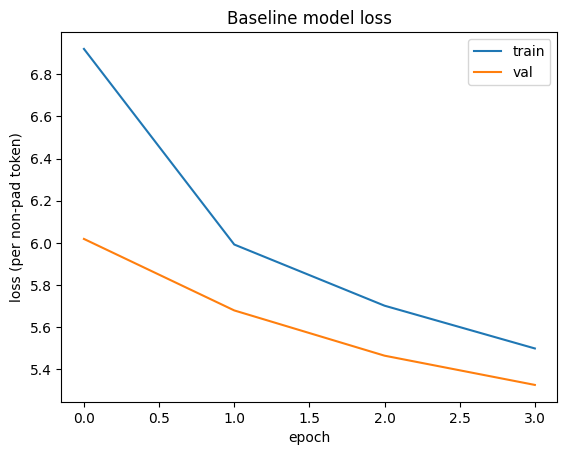

In [11]:
plt.figure()
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.xlabel("epoch")
plt.ylabel("loss (per non-pad token)")
plt.title("Baseline model loss")
plt.legend()
plt.show()


In [12]:
@torch.no_grad()
def translate_sentence(model, src_sentence: str, max_new_tokens: int = 40) -> str:
    model.eval()
    src_norm = normalize_text(src_sentence)
    src_ids = encode_sentence(src_norm)

    tokens = [BOS] + src_ids + [SEP]
    if len(tokens) > MAX_LEN_TOKENS - 1:
        tokens = tokens[:MAX_LEN_TOKENS - 1]

    x = torch.tensor(tokens, dtype=torch.long, device=device).unsqueeze(0)
    out = model.generate(x, max_new_tokens=max_new_tokens)
    out_tokens = out[0].tolist()

    # segment after SEP until EOS
    if SEP in out_tokens:
        start = out_tokens.index(SEP) + 1
    else:
        start = len(tokens)

    if EOS in out_tokens[start:]:
        end = start + out_tokens[start:].index(EOS)
    else:
        end = len(out_tokens)

    pred_tgt_tokens = out_tokens[start:end]
    return decode_tokens(pred_tgt_tokens)

# quick sanity check on a few validation pairs
for i in range(3):
    s_en, s_de = random.choice(val_pairs)
    print("EN:", s_en)
    print("GT DE:", s_de)
    print("PRED:", translate_sentence(model, s_en))
    print()


EN: cesare borgia was considered cruel; notwithstanding, his cruelty reconciled the romagna, unified it, and restored it to peace and loyalty.
GT DE: diese grausamkeit hatte die provinz romagna zusammen gehalten, in einigkeit, in frieden und in treuer unterwürfigkeit.
PRED: »was zu duel, war er <unk> daß sie hatte thatcher, ganz <unk> habe. <unk> und <unk> und er ganz <unk> <unk> werke bemerkte <unk> genommen aus einem augenblick <unk>

EN: 'you call it cruelty when a husband gives his wife complete freedom while he affords her honourable shelter, on the one condition that she should observe the laws of propriety.
GT DE: »das nennen sie grausamkeit, wenn ein mann seiner frau alle freiheit läßt, sie mit dem ehrenschilde seines namens deckt und nur die einzige bedingung stellt, daß der anstand gewahrt werde.
PRED: »er machte aber zur <unk> sagte sie während er recht noch <unk> sprach vernehmen nicht zu die notwendig jaschwin, es wandte mit einer bitten wie die ear. jahr <unk> dahin nehme

In [13]:
def ngrams(tokens: List[str], n: int):
    return [tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)]

def corpus_bleu(references, hypotheses, max_n: int = 4) -> float:
    """
    Simple corpus BLEU with uniform weights up to max_n.
    references: list of reference token lists
    hypotheses: list of hypothesis token lists
    """
    weights = [1.0 / max_n] * max_n
    p_ns = []

    for n in range(1, max_n+1):
        num = 0
        den = 0
        for ref, hyp in zip(references, hypotheses):
            ref_ngrams = ngrams(ref, n)
            hyp_ngrams = ngrams(hyp, n)

            # reference max counts
            ref_counts = {}
            for g in ref_ngrams:
                ref_counts[g] = max(ref_counts.get(g, 0), ref_ngrams.count(g))

            # hypothesis counts
            hyp_counts = {}
            for g in hyp_ngrams:
                hyp_counts[g] = hyp_counts.get(g, 0) + 1

            for g in hyp_counts:
                num += min(hyp_counts[g], ref_counts.get(g, 0))
            den += len(hyp_ngrams)

        p_n = num / den if den > 0 else 0.0
        p_ns.append(p_n if p_n > 0 else 1e-9)  # avoid log(0)

    # brevity penalty
    ref_len = sum(len(r) for r in references)
    hyp_len = sum(len(h) for h in hypotheses)

    if hyp_len == 0:
        return 0.0
    if hyp_len > ref_len:
        bp = 1.0
    else:
        bp = math.exp(1 - ref_len / hyp_len)

    s = sum(w * math.log(p) for w, p in zip(weights, p_ns))
    bleu = bp * math.exp(s)
    return bleu

def lcs_length(a: List[str], b: List[str]) -> int:
    m, n = len(a), len(b)
    dp = [[0]*(n+1) for _ in range(m+1)]
    for i in range(m):
        for j in range(n):
            if a[i] == b[j]:
                dp[i+1][j+1] = dp[i][j] + 1
            else:
                dp[i+1][j+1] = max(dp[i][j+1], dp[i+1][j])
    return dp[m][n]

def rouge_l_score(reference: List[str], hypothesis: List[str]) -> float:
    lcs = lcs_length(reference, hypothesis)
    if lcs == 0:
        return 0.0
    prec = lcs / len(hypothesis) if hypothesis else 0.0
    rec  = lcs / len(reference) if reference else 0.0
    if prec + rec == 0:
        return 0.0
    return 2 * prec * rec / (prec + rec)

def corpus_rouge_l(references, hypotheses) -> float:
    scores = []
    for r, h in zip(references, hypotheses):
        scores.append(rouge_l_score(r, h))
    return sum(scores) / max(1, len(scores))


In [14]:
@torch.no_grad()
def evaluate_translation_metrics(model, pairs, max_samples=200):
    model.eval()
    refs = []
    hyps = []

    sample_pairs = pairs[:max_samples]
    for src, tgt in sample_pairs:
        pred = translate_sentence(model, src)
        ref_tokens = tgt.split()
        hyp_tokens = pred.split()
        refs.append(ref_tokens)
        hyps.append(hyp_tokens)

    bleu = corpus_bleu(refs, hyps, max_n=4)
    rouge_l = corpus_rouge_l(refs, hyps)
    return bleu, rouge_l

baseline_bleu, baseline_rouge_l = evaluate_translation_metrics(
    model, val_pairs, max_samples=200
)

print(f"Baseline BLEU:    {baseline_bleu:.4f}")
print(f"Baseline ROUGE-L: {baseline_rouge_l:.4f}")


Baseline BLEU:    0.0000
Baseline ROUGE-L: 0.0589


## Experiments: model size vs translation quality

We now run a small sweep over a couple of model hyperparameters and compare BLEU / ROUGE-L.

To keep runtimes manageable, each configuration is trained for a small number of epochs.
For more meaningful final numbers, **increase the number of epochs** and/or the dataset size.


In [15]:
def run_experiment(n_embd: int, n_layer: int, max_epochs: int = 3, lr: float = 3e-4):
    print(f"\n=== Experiment: n_embd={n_embd}, n_layer={n_layer} ===")
    config = ModelConfig(
        vocab_size=vocab_size,
        n_embd=n_embd,
        n_head=4,
        n_layer=n_layer,
        dropout=0.1,
        block_size=MAX_LEN_TOKENS,
    )
    model, train_losses, val_losses = train_model(config, max_epochs=max_epochs, lr=lr)
    bleu, rouge_l = evaluate_translation_metrics(model, val_pairs, max_samples=150)
    print(f"BLEU={bleu:.4f}, ROUGE-L={rouge_l:.4f}")

    return {
        "n_embd": n_embd,
        "n_layer": n_layer,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "bleu": bleu,
        "rouge_l": rouge_l,
    }

experiment_configs = [
    (64, 2),
    (128, 2),
    (128, 4),
]

experiment_results = []
for n_embd, n_layer in experiment_configs:
    result = run_experiment(n_embd, n_layer, max_epochs=3, lr=3e-4)
    experiment_results.append(result)



=== Experiment: n_embd=64, n_layer=2 ===
epoch 01 | train loss 7.5960 | val loss 6.6004 | 10.5s
epoch 02 | train loss 6.5615 | val loss 6.1339 | 10.6s
epoch 03 | train loss 6.1855 | val loss 5.9290 | 10.7s
BLEU=0.0000, ROUGE-L=0.0308

=== Experiment: n_embd=128, n_layer=2 ===
epoch 01 | train loss 7.0441 | val loss 6.1286 | 13.3s
epoch 02 | train loss 6.1053 | val loss 5.7825 | 13.3s
epoch 03 | train loss 5.8157 | val loss 5.5646 | 13.3s
BLEU=0.0000, ROUGE-L=0.0457

=== Experiment: n_embd=128, n_layer=4 ===
epoch 01 | train loss 6.9826 | val loss 6.0803 | 15.9s
epoch 02 | train loss 6.0214 | val loss 5.6887 | 16.3s
epoch 03 | train loss 5.7048 | val loss 5.4654 | 16.2s
BLEU=0.0000, ROUGE-L=0.0557


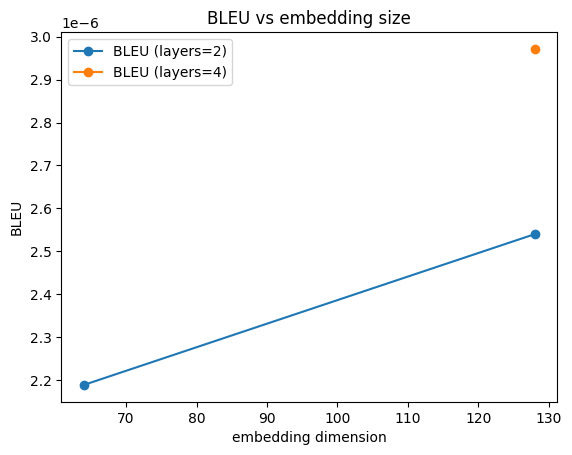

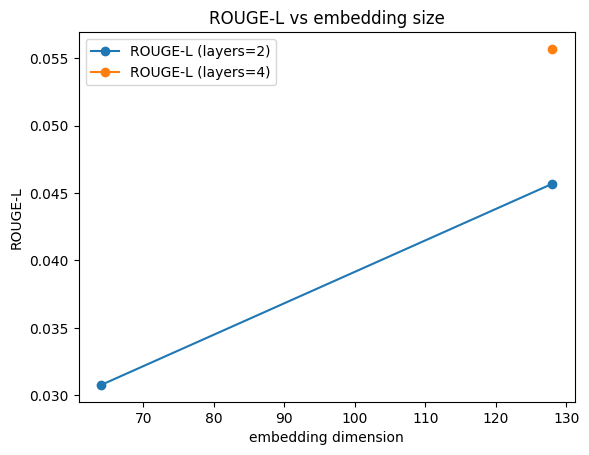

In [16]:
embds  = [r["n_embd"]  for r in experiment_results]
bleus  = [r["bleu"]    for r in experiment_results]
rouges = [r["rouge_l"] for r in experiment_results]
layers = [r["n_layer"] for r in experiment_results]

plt.figure()
for n_layer in sorted(set(layers)):
    xs = [e for e, l in zip(embds, layers) if l == n_layer]
    ys_b = [b for b, l in zip(bleus, layers) if l == n_layer]
    plt.plot(xs, ys_b, marker="o", label=f"BLEU (layers={n_layer})")

plt.xlabel("embedding dimension")
plt.ylabel("BLEU")
plt.title("BLEU vs embedding size")
plt.legend()
plt.show()

plt.figure()
for n_layer in sorted(set(layers)):
    xs = [e for e, l in zip(embds, layers) if l == n_layer]
    ys_r = [r for r, l in zip(rouges, layers) if l == n_layer]
    plt.plot(xs, ys_r, marker="o", label=f"ROUGE-L (layers={n_layer})")

plt.xlabel("embedding dimension")
plt.ylabel("ROUGE-L")
plt.title("ROUGE-L vs embedding size")
plt.legend()
plt.show()


## Summary & next steps

We:
- Built a **small decoder-only Transformer** from scratch for EN→DE translation.
- Trained it as a **translation language model** on OPUS Books.
- Computed **BLEU** and **ROUGE-L** (word-level, implemented manually).
- Ran small **hyperparameter sweeps** over embedding size / depth and plotted their impact.

Possible extensions:
- Increase **training epochs**, dataset size, and model capacity.
- Use better decoding (e.g. **beam search**).
- Explore different datasets (TED talks, Multi30k, etc.).
- Add learning rate schedules, label smoothing, or weight decay.
